# Workflow for importing, processing, aggregating, and importing CORDEX ensemble stats for mean temperature

In [1]:
import json
import pandas as pd
import geopandas as gpd
import xarray as xr
from dhis2eo.data.cds import cordex
from dhis2_client import DHIS2Client
from dhis2eo.integrations.pandas import dataframe_to_dhis2_json

In [2]:
# Params
DHIS2_BASE_URL = 'https://climate.im.dhis2.org/climate-projections-42'
DHIS2_USERNAME = 'admin'
DHIS2_PASSWORD = 'district'
DHIS2_ORG_UNIT_LEVEL = 2

In [3]:
# Connect
client = DHIS2Client(
    base_url=DHIS2_BASE_URL,
    username=DHIS2_USERNAME,
    password=DHIS2_PASSWORD,
)
info = client.get_system_info()

# Check if everything is working.
# You should see your current DHIS2 version info.
print("Current DHIS2 version:", info["version"])

### Get org units GeoJSON from DHIS2
org_units_geojson = client.get_org_units_geojson(level=DHIS2_ORG_UNIT_LEVEL)

# Convert GeoJSON to geopandas
org_units = gpd.read_file(json.dumps(org_units_geojson))
org_units

Current DHIS2 version: 2.42.3.1


,id,code,name,level,parent,parentGraph,groups,geometry
0,O6uvpzGd5pu,OU_264,Bo,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy]","POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,fdc6uOvgoji,OU_193190,Bombali,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, J40PpdN4Wkk, GGghZsfu7qV]","POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,lc3eMKXaEfw,OU_197385,Bonthe,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy, GGghZsfu7qV]","MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,jUb8gELQApl,OU_204856,Kailahun,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, nlX2VoouN63]","POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,PMa2VCrupOd,OU_211212,Kambia,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, b0EsAxm8Nge, nlX2Vo...","MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,kJq2mPyFEHo,OU_222616,Kenema,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL]","POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,qhqAxPSTUXp,OU_226213,Koinadugu,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Vth0fbpFcsO,OU_233310,Kono,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,jmIPBj66vD6,OU_246990,Moyamba,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, jqBqIXoXpfy]","MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,TEQlaapDQoK,OU_254945,Port Loko,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, b0EsAxm8Nge]","MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


## Download and save to reduced file format

In [5]:
# begin
start_year = 2021
end_year = 2050
dirname = '../test_outputs/cordex'
variables = ['2m_air_temperature']
region = 'africa'
resolution = '0_22_degree_x_0_22_degree'
scenarios = ['rcp_2_6', 'rcp_8_5']

files = []
for scenario in scenarios:
    print('Scenario', scenario)
    prefix = f'cordex_temperature_{scenario}'
    scenario_models = cordex.MODELS['africa'][resolution][scenario]
    subfiles = cordex.daily.get(start_year, end_year, region, dirname, prefix, variables, scenario, resolution, scenario_models, overwrite=False)
    print('-->', subfiles)
    files.extend(subfiles)

files

Scenario rcp_2_6
GCM model MOHC-HadGEM2-ES
RCM model CLMcom-KIT-CCLM5-0-15
Years 2021 to 2025
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Years 2026 to 2030
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
Years 2031 to 2035
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
Years 2036 to 2040
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
Years 2041 to 2045
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\test

[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc'),
 WindowsPath('C:/Users

In [ ]:
# get bbox
xmin,ymin,xmax,ymax = map(float, org_units.total_bounds)

# collect and prep files before concat
datasets = []
for fil in files:

    # open dataset
    print('-------->', fil)
    d = xr.open_dataset(fil, chunks={"time": 500}) #, "rlat": 100, "rlon": 100})

    # fix datasets with lon 0-360
    # TODO: this likely won't detect 0-360 for South American domain? 
    if d.lon.max() > 180:
        lon = ((d.lon + 180) % 360) - 180
        d = d.assign_coords(lon=lon)
        print('longitude coordinates converted from 0 to 360, to -180 to 180')
    
    # round dataset coordinates due to minor cross-model decimal differences
    import numpy as np
    d = d.assign_coords(
        rlon=np.round(d.rlon, 4),
        rlat=np.round(d.rlat, 4),
        lon=np.round(d.lon, 4),
        lat=np.round(d.lat, 4),
    )

    # subset to bbox
    mask = (
        (d.lat >= ymin) & (d.lat <= ymax) &
        (d.lon >= xmin)  & (d.lon <= xmax)
    ).compute()
    subset = d.where(mask, drop=True).compute()
    
    # aggregate to months to avoid calendar trouble and daily is mostly noise
    grouped = subset['tas'].resample(time="MS", skipna=True)
    monthly = xr.Dataset({
        "tas_mean": grouped.mean(dim="time"),
        #"tas_min": grouped.min(dim="time"), # if we're looking at mean temp ('tas') this = min daily avg which isnt interesting
        #"tas_max": grouped.max(dim="time"), # if we're looking at mean temp ('tas') this = max daily avg which isnt interesting
    })
    # print('calendar', subset['time'].encoding.get('calendar'))
    # subset.coords['year_month'] = subset['time'].dt.strftime('%Y-%m')
    # grouped = subset['tas'].groupby('year_month')
    # monthly = xr.Dataset({
    #     "tas_mean": grouped.mean(dim="time"),
    #     "tas_min": grouped.min(dim="time"),
    #     "tas_max": grouped.max(dim="time"),
    #     "count": grouped.count(dim="time"),
    # })
    # monthly = monthly.rename({'year_month': 'time'})
    # monthly['time'] = np.array([np.datetime64(f'{y_m}-01') for y_m in monthly['time'].values])
    # print(monthly)

    # convert to numpy datetime after aggregating to months
    if hasattr(monthly.indexes["time"], 'to_datetimeindex'):
        time = pd.DatetimeIndex([
            pd.Timestamp(t.year, t.month, 1) for t in monthly.time.values
        ])
        monthly = monthly.assign_coords(time=time)
    else:
        print('time dim already in numpy datetime format')
    
    # make gcm-rcm combo a dimension that we can select on after concat
    gcm = d.model_id
    rcm = d.driving_model_id
    ensemble_id = f'{gcm}__{rcm}'
    monthly = monthly.assign_coords(ensemble=ensemble_id).expand_dims("ensemble")
    
    # make scenario a dimension that we can select on after concat
    scenario_id = d.experiment_id
    monthly = monthly.assign_coords(scenario=scenario_id).expand_dims("scenario")
    
    # add to list
    datasets.append(monthly)

--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_8_5_MPI-M-MPI-ESM-LR_GERICS-REMO2015_2026-2030.nc
longitude coordinates converted from 0 to 360, to -180 to 180
calendar proleptic_gregorian
<xarray.Dataset> Size: 221kB
Dimensions:   (rlat: 14, rlon: 13, time: 60)
Coordinates:
  * rlat      (rlat) float64 112B 6.93 7.15 7.37 7.59 ... 9.13 9.35 9.57 9.79
  * rlon      (rlon) float64 104B -13.09 -12.87 -12.65 ... -10.89 -10.67 -10.45
  * time      (time) datetime64[s] 480B 2026-01-01 2026-02-01 ... 2030-12-01
    lat       (rlat, rlon) float32 728B 6.93 6.93 6.93 6.93 ... 9.79 9.79 9.79
    lon       (rlat, rlon) float32 728B -13.09 -12.87 -12.65 ... -10.67 -10.45
    height    float64 8B 2.0
Data variables:
    tas_mean  (time, rlat, rlon) float32 44kB 300.2 300.2 300.2 ... 294.2 293.8
    tas_min   (time, rlat, rlon) float32 44kB 299.5 299.6 299.5 ... 292.3 292.0
    tas_max   (time, rlat, rlon) float32 44kB 301.2 301.1 301.1 ... 297.9

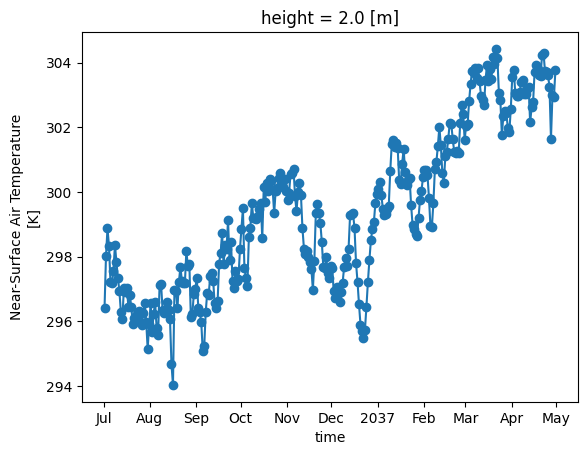

In [9]:
# quick sanity timeseries test for entire country
country = subset.mean(dim=["rlat","rlon"])
country['tas'].sel(time=slice('2036-07', '2037-04')).plot(x="time", marker="o", linestyle="-", add_legend=False)

In [56]:
# concat
ds = xr.combine_by_coords(
    datasets, 
    compat='override',
    coords='minimal',
    combine_attrs="override",
)
ds

<xarray.Dataset> Size: 660kB
Dimensions:   (scenario: 1, ensemble: 1, time: 180, rlat: 14, rlon: 13)
Coordinates:
  * scenario  (scenario) <U5 20B 'rcp26'
  * ensemble  (ensemble) <U38 152B 'CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES'
  * time      (time) datetime64[s] 1kB 2021-01-01 2021-02-01 ... 2035-12-01
  * rlat      (rlat) float64 112B 6.93 7.15 7.37 7.59 ... 9.13 9.35 9.57 9.79
  * rlon      (rlon) float64 104B -13.09 -12.87 -12.65 ... -10.89 -10.67 -10.45
    lon       (rlat, rlon) float64 1kB -13.09 -12.87 -12.65 ... -10.67 -10.45
    lat       (rlat, rlon) float64 1kB 6.93 6.93 6.93 6.93 ... 9.79 9.79 9.79
    height    float64 8B 2.0
Data variables:
    tas_mean  (scenario, ensemble, time, rlat, rlon) float32 131kB 301.1 ... ...
    tas_min   (scenario, ensemble, time, rlat, rlon) float32 131kB 299.7 ... ...
    tas_max   (scenario, ensemble, time, rlat, rlon) float32 131kB 302.1 ... ...
    count     (scenario, ensemble, time, rlat, rlon) int64 262kB 30 30 ... 30 30

In [20]:
# save to disk so can reuse later
ds.to_netcdf('../test_outputs/cordex/cordex_temperature_sierra_leone5.nc')

## Run from saved output

In [4]:
# open from disk
ds = xr.open_dataset('../test_outputs/cordex/cordex_temperature_sierra_leone5.nc')

In [5]:
# convert to kelvin
ds = ds - 273.15
ds

<xarray.Dataset> Size: 4MB
Dimensions:   (time: 360, scenario: 2, rlon: 13, rlat: 14, ensemble: 7)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2021-01-01 2021-02-01 ... 2050-12-01
  * scenario  (scenario) <U5 40B 'rcp26' 'rcp85'
  * rlon      (rlon) float64 104B -13.09 -12.87 -12.65 ... -10.89 -10.67 -10.45
  * rlat      (rlat) float64 112B 6.93 7.15 7.37 7.59 ... 9.13 9.35 9.57 9.79
  * ensemble  (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERICS-...
    lon       (rlat, rlon) float64 1kB ...
    lat       (rlat, rlon) float64 1kB ...
    height    float64 8B ...
Data variables:
    tas_mean  (scenario, ensemble, time, rlat, rlon) float32 4MB nan ... 23.07

In [6]:
ds_ens = xr.Dataset({
    "tas_mean_ens_mean": ds['tas_mean'].mean(dim="ensemble"),
    "tas_mean_ens_min": ds['tas_mean'].min(dim="ensemble"),
    "tas_mean_ens_max": ds['tas_mean'].max(dim="ensemble"),
})
ds_ens

<xarray.Dataset> Size: 2MB
Dimensions:            (time: 360, scenario: 2, rlon: 13, rlat: 14)
Coordinates:
  * time               (time) datetime64[ns] 3kB 2021-01-01 ... 2050-12-01
  * scenario           (scenario) <U5 40B 'rcp26' 'rcp85'
  * rlon               (rlon) float64 104B -13.09 -12.87 ... -10.67 -10.45
  * rlat               (rlat) float64 112B 6.93 7.15 7.37 ... 9.35 9.57 9.79
    lon                (rlat, rlon) float64 1kB -13.09 -12.87 ... -10.67 -10.45
    lat                (rlat, rlon) float64 1kB 6.93 6.93 6.93 ... 9.79 9.79
    height             float64 8B 2.0
Data variables:
    tas_mean_ens_mean  (scenario, time, rlat, rlon) float32 524kB 26.83 ... 2...
    tas_mean_ens_min   (scenario, time, rlat, rlon) float32 524kB 25.05 ... 2...
    tas_mean_ens_max   (scenario, time, rlat, rlon) float32 524kB 28.9 ... 25.89

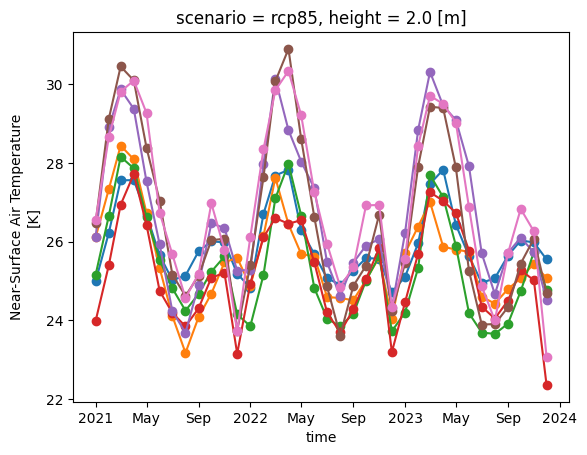

In [13]:
# quick sanity timeseries test for entire country
country = ds.mean(dim=["rlat","rlon"])
country['tas_mean'].sel(scenario='rcp85', time=slice(None, '2023')).plot(x="time", hue='ensemble', marker="o", linestyle="-", add_legend=False)

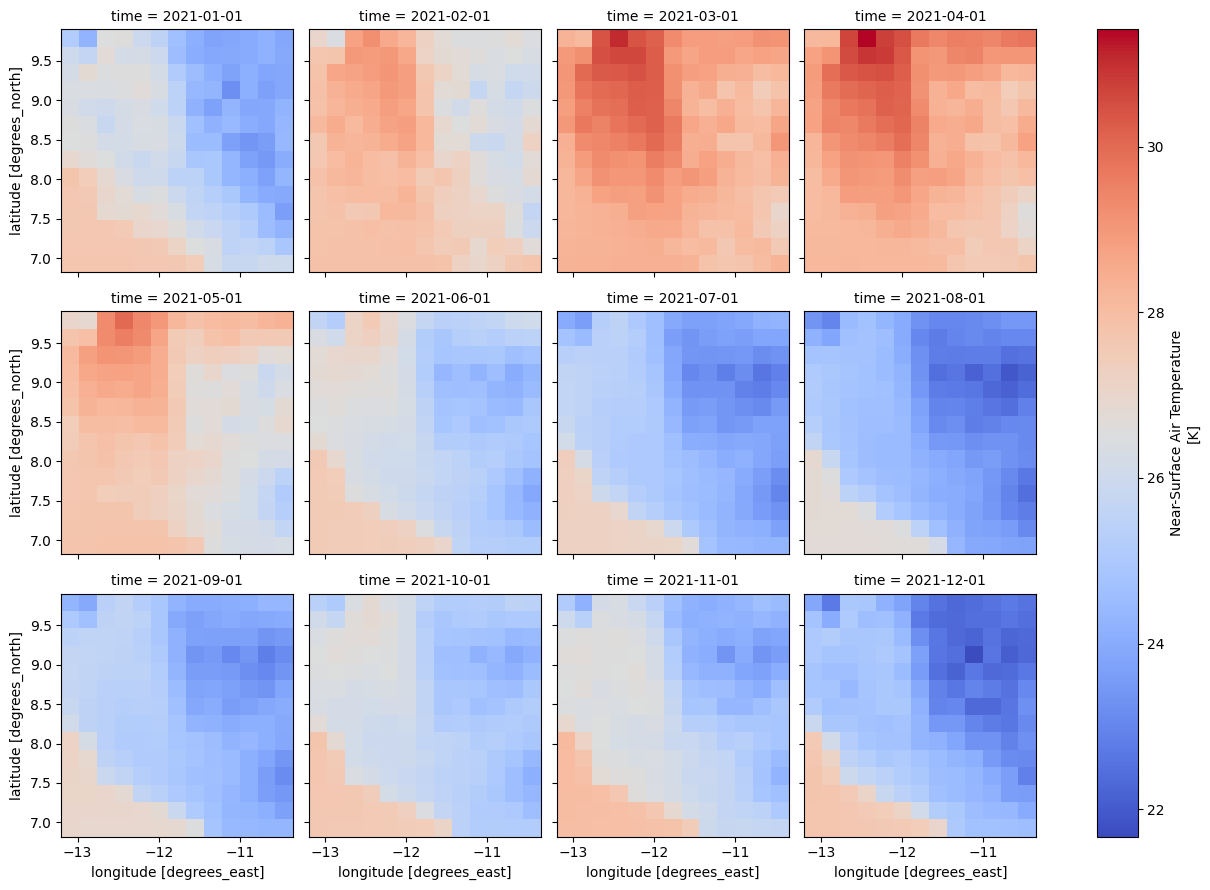

In [31]:
# show months of 2021
grid_means = ds['tas_mean'].sel(scenario='rcp85').mean(dim='ensemble')
grid_means.isel(time=slice(0, 12)).plot(x="lon", y="lat", col='time', col_wrap=4, cmap="coolwarm")

In [7]:
# aggregate with partial overlaps
# TOOD: switch to different library and method
import xagg
ds_renamed = ds_ens.drop_vars(['lon', 'lat']).rename({'rlon':'lon', 'rlat':'lat'})
print(ds_renamed)
weightmap = xagg.pixel_overlaps(ds_renamed, org_units)
aggregated = xagg.aggregate(ds_renamed, weightmap)
ds_org_units = aggregated.to_dataset()[['tas_mean_ens_mean', 'tas_mean_ens_min', 'tas_mean_ens_max', 'id']]
ds_org_units

<xarray.Dataset> Size: 2MB
Dimensions:            (time: 360, scenario: 2, lon: 13, lat: 14)
Coordinates:
  * time               (time) datetime64[ns] 3kB 2021-01-01 ... 2050-12-01
  * scenario           (scenario) <U5 40B 'rcp26' 'rcp85'
  * lon                (lon) float64 104B -13.09 -12.87 -12.65 ... -10.67 -10.45
  * lat                (lat) float64 112B 6.93 7.15 7.37 7.59 ... 9.35 9.57 9.79
    height             float64 8B 2.0
Data variables:
    tas_mean_ens_mean  (scenario, time, lat, lon) float32 524kB 26.83 ... 23.69
    tas_mean_ens_min   (scenario, time, lat, lon) float32 524kB 25.05 ... 22.47
    tas_mean_ens_max   (scenario, time, lat, lon) float32 524kB 28.9 ... 25.89
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas_mean_ens_mean...
aggregating tas_mean_ens_min...
aggregating tas_mean_ens_max...
all variables aggregated to polygons!


<xarray.Dataset> Size: 228kB
Dimensions:            (poly_idx: 13, scenario: 2, time: 360)
Coordinates:
  * poly_idx           (poly_idx) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * scenario           (scenario) <U5 40B 'rcp26' 'rcp85'
  * time               (time) datetime64[ns] 3kB 2021-01-01 ... 2050-12-01
Data variables:
    tas_mean_ens_mean  (poly_idx, scenario, time) float64 75kB 23.98 ... 26.82
    tas_mean_ens_min   (poly_idx, scenario, time) float64 75kB 21.38 ... 25.62
    tas_mean_ens_max   (poly_idx, scenario, time) float64 75kB 25.94 ... 28.55
    id                 (poly_idx) object 104B 'O6uvpzGd5pu' ... 'at6UHUQatSo'

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': 'Poly #0: O6uvpzGd5pu; OU_264; Bo; 2; ImspTQPwCqd'}>)

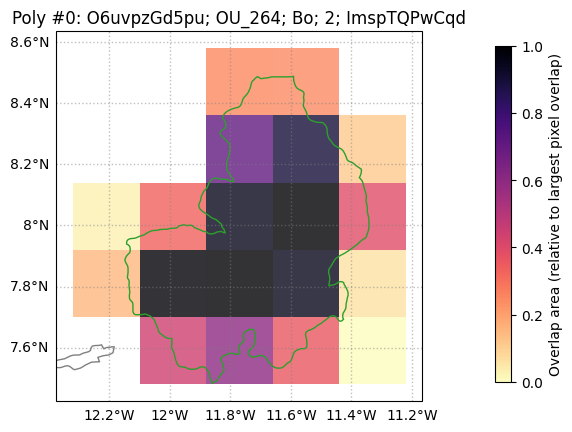

In [28]:
# diagnostic visualization of pixel overlaps
weightmap.diag_fig(0, ds_renamed)

In [8]:
dataframe = ds_org_units.to_dataframe().reset_index()
dataframe

,poly_idx,scenario,time,tas_mean_ens_mean,tas_mean_ens_min,tas_mean_ens_max,id
0,0,rcp26,2021-01-01,23.983950,21.380792,25.939332,O6uvpzGd5pu
1,0,rcp26,2021-02-01,27.090190,23.627411,30.017374,O6uvpzGd5pu
2,0,rcp26,2021-03-01,28.423938,25.907348,30.931780,O6uvpzGd5pu
3,0,rcp26,2021-04-01,28.154160,26.387304,29.992047,O6uvpzGd5pu
4,0,rcp26,2021-05-01,27.031477,25.731531,28.343755,O6uvpzGd5pu
...,...,...,...,...,...,...,...
9355,12,rcp85,2050-08-01,26.477106,25.981306,27.703427,at6UHUQatSo
9356,12,rcp85,2050-09-01,26.864112,26.262023,28.094062,at6UHUQatSo
9357,12,rcp85,2050-10-01,27.615861,26.950367,28.982537,at6UHUQatSo
9358,12,rcp85,2050-11-01,28.153510,26.918969,29.567376,at6UHUQatSo


## Create metadata

In [11]:
data_elements = [
    {
        "name": "2m Temperature, Mean (CORDEX RCP 8.5, Ensemble Mean)",
        "shortName": "Temp Mean - RCP85 Ens Mean",
        "code": "TEMP_MEAN_DAILY_MEAN_ENS_MEAN_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "AVERAGE",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Mean (CORDEX RCP 8.5, Ensemble Min)",
        "shortName": "Temp Mean - RCP85 Ens Min",
        "code": "TEMP_MEAN_DAILY_MEAN_ENS_MIN_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "AVERAGE",
        "domainType": "AGGREGATE"
    },
    {
        "name": "2m Temperature, Mean (CORDEX RCP 8.5, Ensemble Max)",
        "shortName": "Temp Mean - RCP85 Ens Max",
        "code": "TEMP_MEAN_DAILY_MEAN_ENS_MAX_RCP85_CORDEX",
        "valueType": "NUMBER",
        "aggregationType": "AVERAGE",
        "domainType": "AGGREGATE"
    },
]
de_ids = []
for de in data_elements:
    de_created = client.create_data_element(de)
    de_ids.append( de_created['response']['uid'] )
    print(f"Data element creation status: {de_created['status']} and UID: {de_created['response']['uid']}")

Data element creation status: OK and UID: I4I3LyjYpyl
Data element creation status: OK and UID: NEWwUQP9mu1
Data element creation status: OK and UID: unBxcKIL1rK


In [38]:
data_set = {
    "name": "Monthly CORDEX climate projections", 
    "shortName": "Monthly climate projections",
    "periodType": "Monthly",
    "dataSetElements": [
        {
            "dataElement": {"id": de_id},
        }
        for de_id in de_ids
    ]
}

data_set_created = client.create_data_set(data_set)
print(f"Data set creation status: {data_set_created['status']} and UID: {data_set_created['response']['uid']}")

Data set creation status: OK and UID: uCAqKFWakSX


## Import to DHIS2

In [12]:
DRY_RUN = 'false'

In [13]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tas_mean_ens_mean',              # column containing the value
    data_element_id = 'TEMP_MEAN_DAILY_MEAN_ENS_MEAN_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [14]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tas_mean_ens_min',              # column containing the value
    data_element_id = 'TEMP_MEAN_DAILY_MEAN_ENS_MIN_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}

In [15]:
payload = dataframe_to_dhis2_json(
    df = dataframe.query("scenario == 'rcp85'"),                        # pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'time',      # column containing the period
    value_col = 'tas_mean_ens_max',              # column containing the value
    data_element_id = 'TEMP_MEAN_DAILY_MEAN_ENS_MAX_RCP85_CORDEX' # id of the DHIS2 data element
)
import_params = {'dryRun': DRY_RUN, 'dataElementIdScheme': 'CODE'}
res = client.post("/api/dataValueSets", json=payload, params=import_params)
res['response']['importCount']

{'imported': 4680, 'updated': 0, 'ignored': 0, 'deleted': 0}